In [1]:
import json
import numpy as np
import lmfit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from lmfit import Parameters, minimize, report_fit
from lmfit.models import LinearModel
import sys
import os

temps = []
reps = []
kdeg_vals = []

for temp in [25, 30, 37, 45, 52, 60]:
    for rep in ['a', 'b']:
        if temp == 30 and rep =='b':
            continue
        # read json-like file /home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/52_a.sav
        with open(f'/home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/{temp}_{rep}.sav') as f:
            data = json.load(f)
        kdeg_val = 1 / data['params'][1][1]
        temps.append(temp)
        reps.append(rep)
        kdeg_vals.append(kdeg_val)

df_kdeg = pd.DataFrame({'temperature': temps, 'replicate': reps, 'kdeg': kdeg_vals})
df_kdeg['lnkdeg'] = np.log(df_kdeg['kdeg'])
df_kdeg['inv_temp'] = 1 / (df_kdeg['temperature'] + 273.15)

# linear fit to get curve
model = lmfit.models.LinearModel()
params = model.make_params()
deg_result = model.fit(df_kdeg['lnkdeg'], params, x=df_kdeg['inv_temp'])
#deg_result.plot(fig_kws={'figsize': (3, 3)})
#plt.show()

# get slope and intercept
slope = deg_result.params['slope'].value
intercept = deg_result.params['intercept'].value

def get_kdeg(temp, slope=slope, intercept=intercept):
    return np.exp(slope / (temp + 273.15) + intercept)

def fmod_model(x, log_kappa, log_kdeg, log_fmod_0):
    kappa = np.exp(log_kappa)
    kdeg = np.exp(log_kdeg)
    fmod_0 = np.exp(log_fmod_0)
    return 1 - np.exp(- (kappa) * (1 - np.exp(-kdeg * x))) + fmod_0

def free_fit(df, temp, global_kdeg = None):
    site_nt = df['site'].astype(str).values[0] + df['base'].values[0]
    x_data = df['reaction_time'] * df['treated']
    y_data = df['fmod_val']

    model = lmfit.Model(fmod_model)

    kdeg0 = get_kdeg(temp)
    kappa0 = -np.log(1 - y_data.max())
    fmod_00 = max(y_data.min(), 1e-6)  # Avoid log(0) errors
    
    params = model.make_params(
        log_kappa=np.log(kappa0), 
        log_kdeg=np.log(kdeg0), 
        log_fmod_0=np.log(fmod_00)
    )
    
    if global_kdeg is not None:
        # this value is log already
        params['log_kdeg'].set(value=global_kdeg, vary=False)

    # No constraints needed since we fit in log space
    result = model.fit(y_data, params, x=x_data)
    
    # # Remove outlier outside of 1.5σ and refit
    outlier = np.abs(result.residual) > 150 * np.std(result.residual)
    
    if sum(outlier) > 0:
        x_data = x_data[~outlier]
        y_data = y_data[~outlier]
    
        # Initial values = values from previous fit
        params = model.make_params(
            log_kappa=result.best_values['log_kappa'], 
            log_kdeg=result.best_values['log_kdeg'], 
            log_fmod_0=result.best_values['log_fmod_0']
        )
        
        result = model.fit(y_data, params, x=x_data)

    return result, site_nt, outlier

# Create parameters
def create_params(free_fit_results):
    fit_params = Parameters()

    log_kdeg_global = free_fit_results['log_kdeg'].mean()

    # iterrate rows of free_fit_results
    for i in range(len(free_fit_results)):
        row = free_fit_results.iloc[i]
        site = row['site'].astype(int)
        log_kappa = row['log_kappa']
        log_fmod_0 = row['log_fmod_0']
        
        fit_params.add(f'log_kappa_{i+1}', value = log_kappa)
        fit_params.add(f'log_kdeg_{i+1}', value = log_kdeg_global)
        fit_params.add(f'log_fmod0_{i+1}', value = log_fmod_0)

        if i > 0:
            fit_params[f'log_kdeg_{i+1}'].expr = f'log_kdeg_1'
    return fit_params

# Create dataset
def create_dataset(free_fit_results, rg_df):
    sites = free_fit_results['site']
    data = []
    x_data = None
    for site in sites:
        site_df = rg_df[rg_df['site'] == site].copy()
        site_df['reaction_time'] = site_df['reaction_time'] * site_df['treated']
        site_df = site_df.sort_values(['site', 'reaction_time'])

        x_data = site_df['reaction_time']
        y_data = site_df['fmod_val']
        data.append(y_data)
    return x_data, np.array(data)

# Define the dataset function using log-transformed parameters
def fmod_dataset(params, i, x):
    """Calculate fmod from parameters for data set."""
    log_kappa = params[f'log_kappa_{i+1}']
    log_kdeg = params[f'log_kdeg_{i+1}']
    log_fmod0 = params[f'log_fmod0_{i+1}']
    return fmod_model(x, log_kappa, log_kdeg, log_fmod0)

# Define the objective function
def objective(params, x, data):
    """Calculate total residual for fits of fmod_model to several data sets."""
    ndata, _ = data.shape
    resid = np.zeros_like(data)

    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - fmod_dataset(params, i, x)

    # Flatten residuals to a 1D array for optimization
    return resid.flatten()

def calculate_global_kdeg(free_fits_results, rg_df):
    global_params = create_params(free_fits_results)
    x_data, y_dataset = create_dataset(free_fits_results, rg_df)

    # make sure each data point has a corresponding time point
    assert x_data.shape[0] == y_dataset.shape[1]

    try:
        out = minimize(objective, global_params, args=(x_data, y_dataset))
    except:
        print('Global fitting failed')
        return None
    return out.params['log_kdeg_1'].value


def main(rg_id, rsq_thres = 0.6):
    rg_id_qc_manual_bad_rg = ['18', '19', '20', '120']
    
    if rg_id in rg_id_qc_manual_bad_rg:
        print(f'    ⚠️  Reaction group {rg_id} is in the manual QC bad list, skipping...')
        return None, None

    # Load from file
    with open("/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/rg_manual_qc_todrop.json", "r") as f:
        todrop_dict = json.load(f)
    
    if str(rg_id) in todrop_dict:
        reaction_time_to_drop = todrop_dict[str(rg_id)]
        print(f'    ⚠️  Reaction group {rg_id} is in the manual QC to drop list, dropping the following reaction times: {reaction_time_to_drop}')
    else:
        reaction_time_to_drop = []

    store_results = []
    resids_free = []
    db_path = '/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.060.developing_DB_input/new.db'
    # Define the query to get fmod_val and reaction_time with a join between the necessary tables
    query = f"""
        SELECT fv.fmod_val, pr.reaction_time, n.site, n.base, pr.treated, fv.read_depth, pr.RT, fv.valtype, pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id, sr.id, pr.done_by
        FROM probing_reactions pr
        JOIN fmod_vals fv ON pr.id = fv.rxn_id
        JOIN nucleotides n ON fv.nt_id = n.id
        JOIN constructs c ON pr.construct_id = c.id
        JOIN sequencing_samples ss ON pr.s_id = ss.id
        JOIN reaction_groups rg ON rg.rxn_id = pr.id
        JOIN sequencing_runs sr on ss.seqrun_id = sr.id
        WHERE rg.rg_id = {rg_id}
        AND fv.fmod_val IS NOT NULL
    """
    # Import data into dataframe
    conn = sqlite3.connect(db_path)
    rg_df = pd.read_sql(query, conn)
    conn.close()
    # Filter RT == 'MRT' and valtype == 'modrate'
    rg_df = rg_df[(rg_df['RT'] == 'MRT') & (rg_df['valtype'] == 'modrate')]

    if rg_id == '2':
        rg_df = rg_df[rg_df['done_by'] == 'RB']
    if rg_id == '3':
        rg_df = rg_df[rg_df['done_by'] == 'EKC']
        # at time zero, only keep under 0.07

    rg_df['reaction_time'] = rg_df['reaction_time'] * rg_df['treated']
    rg_df = rg_df.sort_values(['site', 'reaction_time'])

    # Group by site (sum) and scatter plot vs reaction time
    rg_df_grouped = rg_df.groupby(['reaction_time', 'id']).sum()
    rg_df_grouped = rg_df_grouped.reset_index()
    rg_df_grouped['reaction_time'] = rg_df_grouped['reaction_time'].astype(int)
    rg_df_grouped = rg_df_grouped.sort_values(['reaction_time'])
    # print(rg_df_grouped)

    temp_mode = rg_df_grouped['temperature'].mode()
    rg_df_grouped['adjust_factor'] =  temp_mode.values[0] / rg_df_grouped['temperature']
    rg_df_grouped['adj_fmod_val'] = rg_df_grouped['fmod_val'] * rg_df_grouped['adjust_factor']

    # filter to drop
    rg_df_dropped = rg_df_grouped[rg_df_grouped['reaction_time'].isin(reaction_time_to_drop)]
    rg_df_grouped = rg_df_grouped[~rg_df_grouped['reaction_time'].isin(reaction_time_to_drop)]
    
    # Drop reaction_time_to_drop
    removed_df = rg_df[rg_df['reaction_time'].isin(reaction_time_to_drop)]
    rg_df = rg_df[~rg_df['reaction_time'].isin(reaction_time_to_drop)]

    

    # fig, ax = plt.subplots(figsize = (5, 4))
    # ax.scatter(rg_df_grouped['reaction_time'], rg_df_grouped['fmod_val'])
    # try:
    #     ax.scatter(rg_df_dropped['reaction_time'], rg_df_dropped['adj_fmod_val'], color='red', marker='x')
    # except:
    #     pass
    # ax.set_xlabel('Reaction time (s)')
    # ax.set_ylabel(r'$f_{mod}$')
    # ax.set_title(r'Summed $f_{mod}$ over entire molecule')
    # plt.savefig(f'./{rg_id}_aggregate_fmod_vs_reaction_time.png')
    # plt.clf()

    ############################################################################################################
    # Free fits
    print(f'\n┌── Free fitting started...')

    sites = rg_df['site'].unique()
    os.makedirs('./freefits', exist_ok=True)

    # Free fits
    for site in sites:
        site_df = rg_df[rg_df['site'] == site].copy()
        base = site_df['base'].values[0]
        #print(site_df)
        temp = site_df['temperature'].values[0]

        # replace time 300 with 30
        #site_df.loc[:, 'reaction_time'] = site_df['reaction_time'].replace(300, 30)
        #print('r2', fit_result.rsquared)
        # makedir ./freefits


        try:
            fit_result, site_nt, outliers = free_fit(site_df, temp)
            # fit_result.plot(fig_kws={'figsize': (3, 3)})
            # plt.savefig(f'./freefits/{rg_id}_{site_nt}.png')
            # plt.clf()
            if fit_result.rsquared > rsq_thres:
                store_results.append([site, base, fit_result.best_values['log_kappa'], fit_result.best_values['log_kdeg'], fit_result.best_values['log_fmod_0'], fit_result.rsquared])
                resids_free.append(fit_result.residual)
                print(f'│   ├── ✅ Free fit succeeded at site {site}, appended to store_results')
        except:
            print(f'│   ├── ❌ Free fit failed at site {site}')
            continue

    free_fits_results = pd.DataFrame(store_results, columns=['site', 'base', 'log_kappa', 'log_kdeg', 'log_fmod_0', 'r2'])
    if len(free_fits_results) == 0:
        print(f'└── ⚠️  No successful free fits, returning None.')
        return None, None
    else:
        print(f'└── 🎉 Free fitting complete! Results stored.')

    ############################################################################################################
    # Global fits
    print(f'\n┌── Global fitting started...')

    # filtering to best_fits for global fitting
    # median_kdeg = free_fits_results['log_kdeg'].median()
    # print(f'├── Median log_kdeg: {median_kdeg:.3f}')
    # mode_kdeg = kde_mode(free_fits_results['log_kdeg'], plot=True)
    # print(f'├── Mode log_kdeg: {mode_kdeg:.3f}')
    # std_kdeg = free_fits_results['log_kdeg'].std()
    # filtered_datasets = free_fits_results[
    #     (free_fits_results['log_kdeg'] > mode_kdeg - 2 * std_kdeg) & 
    #     (free_fits_results['log_kdeg'] < mode_kdeg + 2 * std_kdeg)
    # ]
    # filter to A's and C's
    filtered_datasets = free_fits_results[free_fits_results['base'].isin(['A', 'C'])]

    # filter r2 > 0.8
    filtered_datasets = filtered_datasets[filtered_datasets['r2'] > 0.8]

    global_kdeg = calculate_global_kdeg(filtered_datasets, rg_df)
    print(f'├── Global log_kdeg: {global_kdeg}')

    if global_kdeg == None:
        print(f'└── ⚠️  Global fit failed, returning None.')
        return None, None

    ############################################################################################################
    # Refitting with global kdeg

    store_results = []
    #resids = []
    sites = rg_df['site'].unique()
    # mkdir globalfits
    os.makedirs('./globalfits', exist_ok=True)
    for site in sites:
        site_df = rg_df[rg_df['site'] == site]
        temp = site_df['temperature'].values[0]
        try:
            fit_result, site_nt, outliers = free_fit(site_df, temp, global_kdeg)
            # fit_result.plot(fig_kws={'figsize': (3, 3)})
            # plt.savefig(f'./globalfits/{rg_id}_{site_nt}.png')
            # plt.clf()
            if fit_result.rsquared > rsq_thres:
                store_results.append([
                    site, 
                    fit_result.best_values['log_kappa'], 
                    fit_result.best_values['log_kdeg'], 
                    fit_result.best_values['log_fmod_0'], 
                    fit_result.rsquared,
                    fit_result.params['log_kappa'].stderr,
                    fit_result.params['log_kdeg'].stderr,
                    fit_result.params['log_fmod_0'].stderr
                ])
                print(f'│   ├── ✅ Global refit succeeded at site {site}, appended to store_results')
        except:
            print(f'│   ├── ❌ Global refit failed at site {site}')
            continue

    global_refit_results = pd.DataFrame(store_results, columns=['site', 'log_kappa', 'log_kdeg', 'log_fmod_0', 'r2', 'stderr_log_kappa', 'stderr_log_kdeg', 'stderr_log_fmod_0'])
    global_refit_results['rg_id'] = rg_id

    if len(global_refit_results) == 0:
        print(f'└── ⚠️  No successful global refits, returning None.')
        return None, None
    else:
        print(f'└── 🎉 Global fitting complete! Results stored.')

    return free_fits_results, global_refit_results

In [2]:
# take rg_id as argument
rg_id = 59

print(f"[INFO] --- Started processing reaction group {rg_id} ---\n")
free, glob = main(rg_id)
# if none report rg_id:
if free is None:
    print(f'No free fit data for {rg_id}, skipping...')
    sys.exit()
print(f"[INFO] --- Finished processing reaction group {rg_id} ---\n")

[INFO] --- Started processing reaction group 59 ---



/tmp/ipykernel_188279/4181917009.py:217: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rg_df_grouped = rg_df.groupby(['reaction_time', 'id']).sum()
/tmp/ipykernel_188279/4181917009.py:65: RuntimeWarning: divide by zero encountered in log
  log_kappa=np.log(kappa0),



┌── Free fitting started...
│   ├── ❌ Free fit failed at site 1
│   ├── ✅ Free fit succeeded at site 3, appended to store_results
│   ├── ✅ Free fit succeeded at site 4, appended to store_results
│   ├── ✅ Free fit succeeded at site 7, appended to store_results
│   ├── ✅ Free fit succeeded at site 11, appended to store_results
│   ├── ✅ Free fit succeeded at site 12, appended to store_results
│   ├── ✅ Free fit succeeded at site 15, appended to store_results
│   ├── ✅ Free fit succeeded at site 16, appended to store_results
│   ├── ✅ Free fit succeeded at site 17, appended to store_results
│   ├── ✅ Free fit succeeded at site 18, appended to store_results
│   ├── ✅ Free fit succeeded at site 19, appended to store_results
│   ├── ✅ Free fit succeeded at site 20, appended to store_results
│   ├── ✅ Free fit succeeded at site 22, appended to store_results
│   ├── ✅ Free fit succeeded at site 26, appended to store_results
│   ├── ✅ Free fit succeeded at site 29, appended to store_results


In [3]:
rg_id = 63
site = 9

def plot_tc(rg_id, site):
    db_path = '/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.060.developing_DB_input/new.db'
    # Define the query to get fmod_val and reaction_time with a join between the necessary tables
    query = f"""
        SELECT fv.fmod_val, pr.reaction_time, n.site, n.base, pr.treated, fv.read_depth, pr.RT, fv.valtype, pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id, sr.id, pr.done_by
        FROM probing_reactions pr
        JOIN fmod_vals fv ON pr.id = fv.rxn_id
        JOIN nucleotides n ON fv.nt_id = n.id
        JOIN constructs c ON pr.construct_id = c.id
        JOIN sequencing_samples ss ON pr.s_id = ss.id
        JOIN reaction_groups rg ON rg.rxn_id = pr.id
        JOIN sequencing_runs sr on ss.seqrun_id = sr.id
        WHERE rg.rg_id = {rg_id}
        AND fv.fmod_val IS NOT NULL
    """
    # Import data into dataframe
    conn = sqlite3.connect(db_path)
    rg_df = pd.read_sql(query, conn)
    conn.close()
    # Filter RT == 'MRT' and valtype == 'modrate'
    rg_df = rg_df[(rg_df['RT'] == 'MRT') & (rg_df['valtype'] == 'modrate')]

    if rg_id == '2':
        rg_df = rg_df[rg_df['done_by'] == 'RB']
    if rg_id == '3':
        rg_df = rg_df[rg_df['done_by'] == 'EKC']
        # at time zero, only keep under 0.07

    rg_df['reaction_time'] = rg_df['reaction_time'] * rg_df['treated']
    rg_df = rg_df.sort_values(['site', 'reaction_time'])
    all_Cs = rg_df[rg_df['base'] == 'C']
    selectC = all_Cs[(all_Cs['rg_id'] == rg_id) & (all_Cs['site'] == site)]
    temp = selectC['temperature'].values[0]
    # filter under 0.004
    #selectC = selectC[selectC['fmod_val'] < 0.004]
    # filter greater than 0
    #selectC = selectC[selectC['fmod_val'] > 0]
    #filter reaction time > 0
    selectC = selectC[selectC['reaction_time'] > 0]
    
    plt.scatter(selectC['reaction_time'], selectC['fmod_val'])
    plt.xlabel('Reaction time (s)')
    plt.ylabel(r'$f_{mod}$')
    plt.title(f'{temp}°C {site}C')
    plt.show()
    global_kdeg = -9.355820536025135

    #model, site_nt, outliers = free_fit(selectC, temp, global_kdeg)

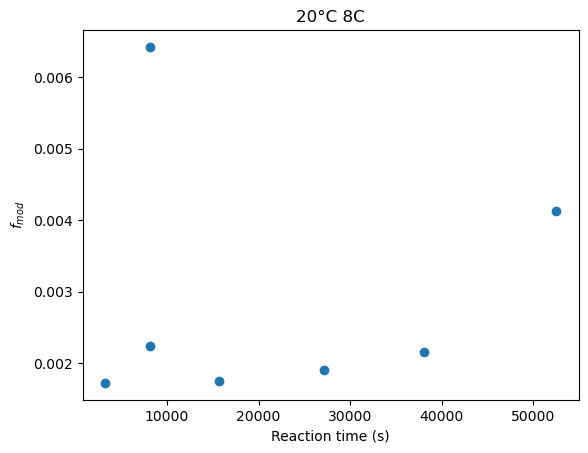

In [21]:
plot_tc(63, 8)